In [1]:
import numpy as np

def read_xcat_bin_image(file_path: str,
                        width: int = 128,
                        height: int = 128,
                        depth: int = 128) -> np.array:
    

    # Define the dimensions of the image


    # Calculate the number of elements in the image
    num_elements = width * height * depth
    
    # Read the binary file
    image_data = np.fromfile(file_path, dtype=np.float32, count=num_elements)
    
    # Reshape the data to the desired dimensions (depth, height, width)
    image_data = image_data.reshape((depth, height, width))
    image_data = np.rot90(image_data, 2)
    return image_data

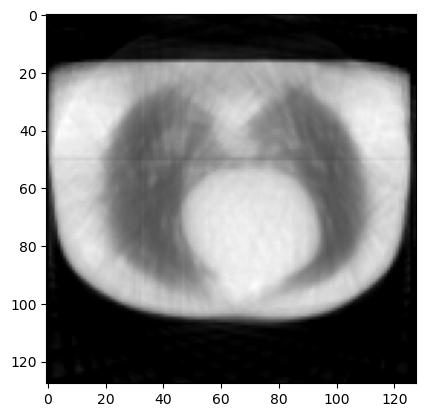

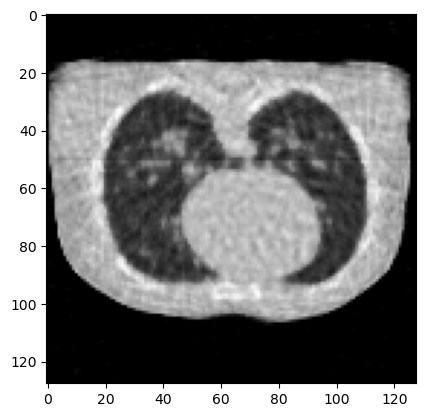

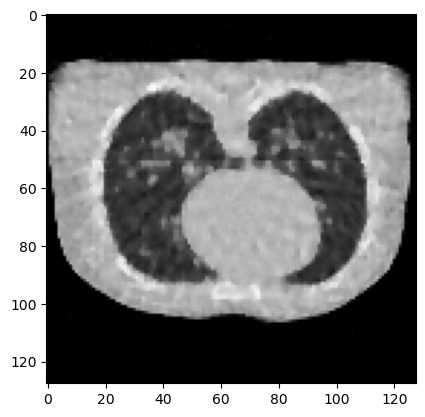

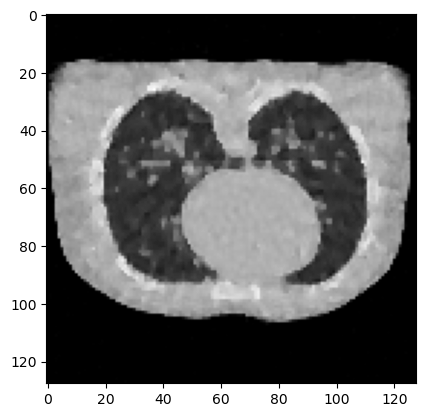

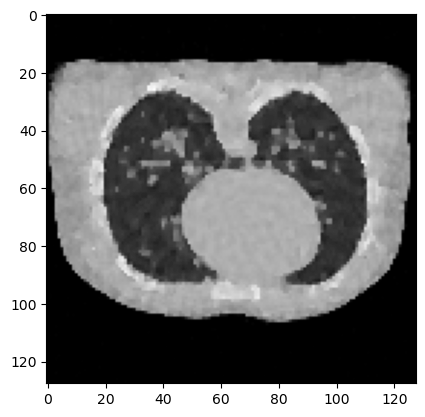

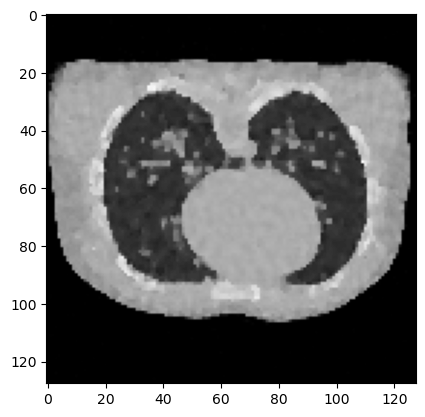

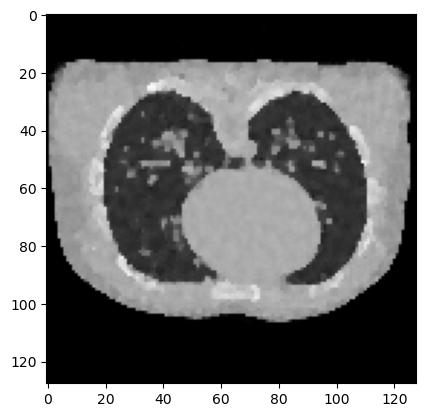

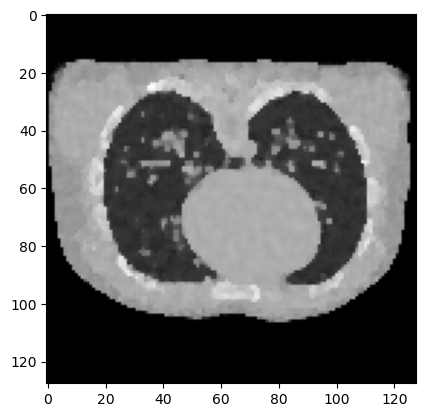

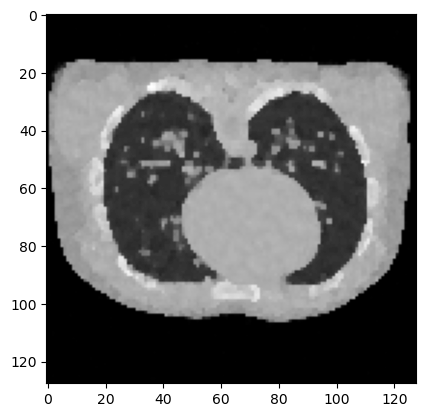

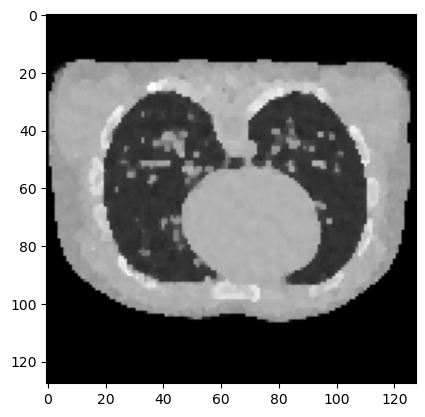

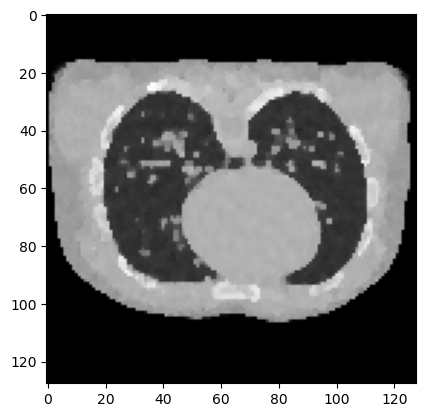

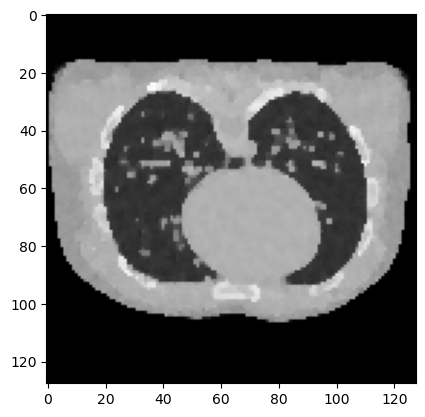

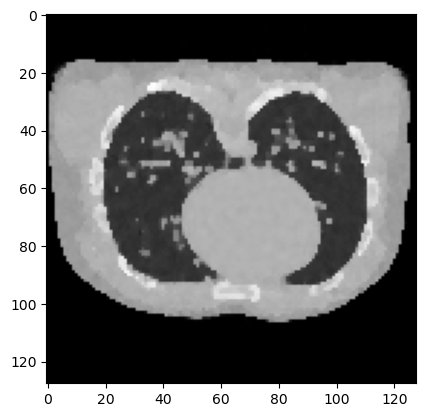

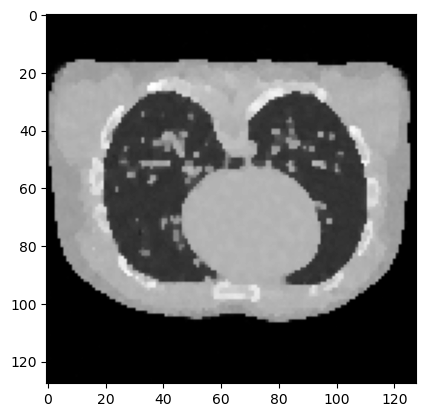

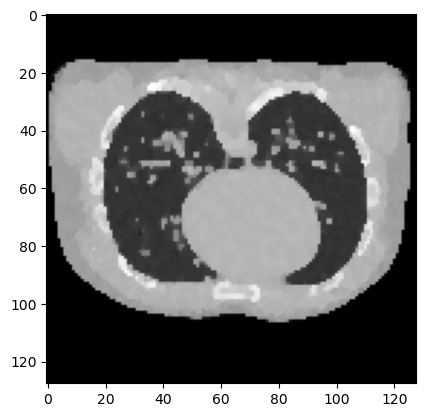

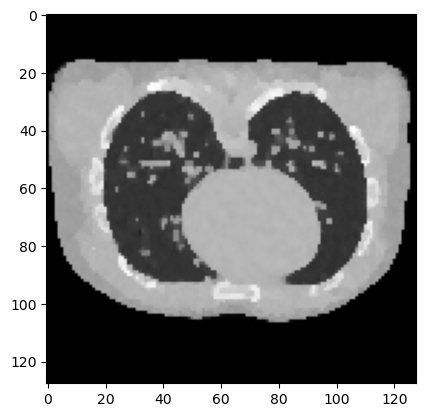

In [3]:
from src.operators.radon import Radon
from src.operators.total_variation import TotalVariation
from src.solvers.pwls import PWLS
from src.solvers.chambolle_pock import ChambollePock


from PIL import Image
import torch
import numpy as np
import torch_radon as tr

device = 'cuda'

n_rays = 128
height, width = 128, 128
n_angles = 52
volume = tr.Volume2D()
volume.set_size(height=height, width=width)
angles = torch.linspace(0, 2 * torch.pi * ((n_angles - 1))/n_angles, n_angles, device=device)

radon = Radon(n_rays=n_rays,
              angles=angles, 
              volume=volume)

tv = TotalVariation(penalty='l1')

I = 3e5
EPS = 1e-10


img_path = '/home/adepaepe/Data/xcat/xcat_extractions/default_phantom_diff_breathing/phantoms/p_1_atn_3.bin'
x_true =read_xcat_bin_image(img_path)[64, :, :]
x_true = torch.from_numpy(x_true.copy()).float().unsqueeze(0).unsqueeze(0).to(device)


sino = radon.transform(x_true)
yi = torch.poisson(I*torch.exp(-sino))
noisy_sino = torch.log(I/ (yi + EPS))


x0 = torch.zeros_like(x_true, device=device)
b = noisy_sino
beta = 3e2
n_iter = 400
n_inner_iter = 10
weights = yi
theta = 1
L = tv.norm(height, width)
sigma = 0.99 * (1e8 / (np.sqrt(1e8 * 1) * L))
tau = 0.99 * (1 / (np.sqrt(1e8 * 1) * L))

solver = ChambollePock(radon=radon, regularizer=tv)

solver.solve( x0,
              b,
              beta,
              tau,
              sigma,
              theta,
              n_iter,
              n_inner_iter,
              weights)
# solver = PWLS(radon=radon, regularizer=tv)

# # import matplotlib.pyplot as plt+
# # plt.imshow(noisy_sino[0, 0, :, :].cpu(), cmap='gray')
# solver.solve(x0,
#              b,
#              beta,
#              n_iter,
#              weights)

In [2]:
weights.shape

NameError: name 'weights' is not defined